# Requirements

In [425]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

In [426]:
# Add as many imports as you need.

## Obesity Analysis


# Dataset Description

## Attributes

- id: represents a unique identifier for each participant or record in the dataset.
- Gender: Represents the gender of the individual.
- Age: Indicates the age of the individual.
- Height - Represents the height of the individual.
- Weight: Represents the weight of the individual.
- FCVC Frequency of Consumption of Vegetables
- NCP - Number of Main Meals per Day
- SMOKE - Indicates whether the individual smokes
- CH2O - Consumption of Water
- TUE - Time Using Electronic Devices
- MTRANS - Mode of Transportation
- NObeyesdad - Nutritional Obesity Status, obesity class

### Target variable
- FAF Frequency of Physical Activity

# Read the dataset

In [430]:
data = pd.read_csv('obesity.csv')
data.head(5)

,Unnamed: 0,id,Gender,Age,Height,Weight,FCVC,NCP,SMOKE,CH2O,FAF,TUE,MTRANS,NObeyesdad
0,0,0.0,Male,24.443011,1.699998,81.669950,2.0,2.983297,no,2.763573,0.000000,0.976473,Public_Transportation,NaN
1,1,1.0,Female,18.000000,1.560000,57.000000,2.0,3.000000,no,NaN,NaN,1.000000,Automobile,Normal_Weight
2,2,2.0,Female,18.000000,NaN,50.165754,NaN,1.411685,no,NaN,0.866045,NaN,Public_Transportation,Insufficient_Weight
3,3,3.0,NaN,20.952737,1.710730,131.274851,3.0,3.000000,no,1.674061,1.467863,0.780199,Public_Transportation,NaN
4,4,NaN,Male,31.641081,1.914186,NaN,NaN,1.971472,no,NaN,1.967973,0.931721,Public_Transportation,Overweight_Level_II


In [431]:
data.drop('Unnamed: 0',axis=1,inplace=True)
data.head(5)

,id,Gender,Age,Height,Weight,FCVC,NCP,SMOKE,CH2O,FAF,TUE,MTRANS,NObeyesdad
0,0.0,Male,24.443011,1.699998,81.669950,2.0,2.983297,no,2.763573,0.000000,0.976473,Public_Transportation,NaN
1,1.0,Female,18.000000,1.560000,57.000000,2.0,3.000000,no,NaN,NaN,1.000000,Automobile,Normal_Weight
2,2.0,Female,18.000000,NaN,50.165754,NaN,1.411685,no,NaN,0.866045,NaN,Public_Transportation,Insufficient_Weight
3,3.0,NaN,20.952737,1.710730,131.274851,3.0,3.000000,no,1.674061,1.467863,0.780199,Public_Transportation,NaN
4,NaN,Male,31.641081,1.914186,NaN,NaN,1.971472,no,NaN,1.967973,0.931721,Public_Transportation,Overweight_Level_II


In [432]:
data.drop('id',axis=1,inplace=True)

Explore the dataset using visualizations of your choice.

In [434]:
def viz(data,columns,numerical):
    plt.figure(figsize=(14,4))
    for i in range(len(columns)):
        plt.subplot(1,len(columns),i+1)
        if numerical:
            plt.hist(data[columns[i]],bins=15)
        else:
            counts = data.groupby(data[columns[i]]).size()
            plt.bar(counts.index.astype(str),counts)
        plt.title(columns[i])

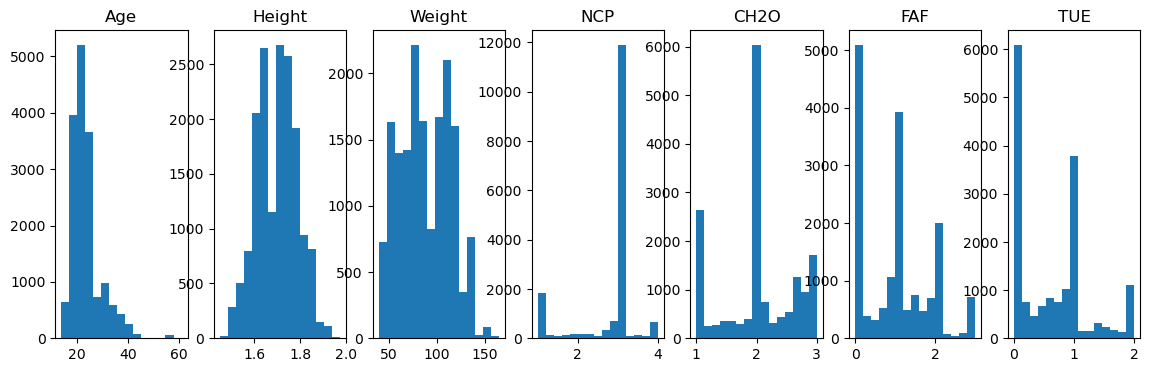

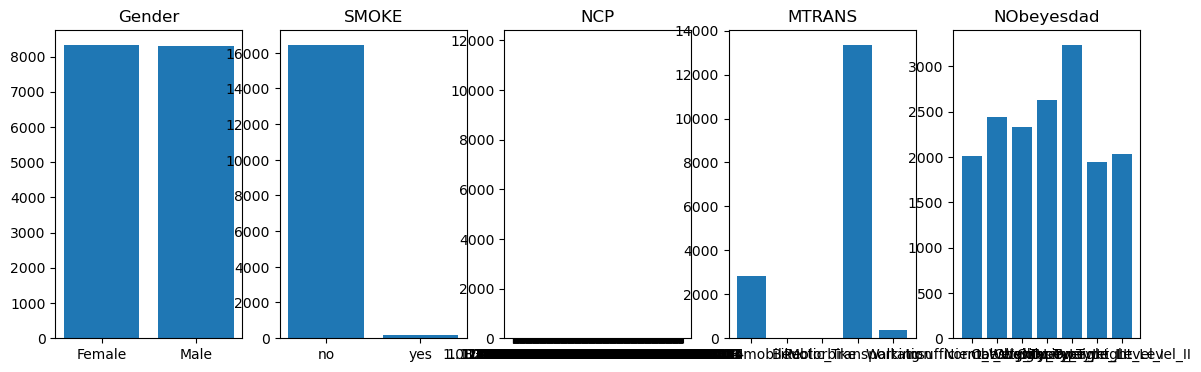

In [435]:
viz(data,['Age','Height','Weight','NCP','CH2O','FAF','TUE'],True)
viz(data,['Gender','SMOKE','NCP','MTRANS','NObeyesdad'],False) #mozeme da zaklucime deka nitu edna numericka kolona nema normalna raspredelba

## Detecting Missing Values
Calculate the percentage of missing values present in each column of the dataset.

In [437]:
data.isnull().sum()

Gender        4124
Age           4150
Height        4091
Weight        4281
FCVC          4117
NCP           4061
SMOKE         4110
CH2O          4161
FAF           4139
TUE           4147
MTRANS        4158
NObeyesdad    4133
dtype: int64

In [438]:
def label_data(data, columns):
  data_copy = data.copy()
  le = LabelEncoder()

  for column in columns:
    non_nans = data_copy[column].dropna()
    le.fit(non_nans)
    data_copy[column] = data_copy[column].apply(lambda x: le.transform([x])[0] if pd.notna(x) else x)

  return data_copy

In [439]:
data = label_data(data,['Gender','MTRANS'])
data.head(5)

,Gender,Age,Height,Weight,FCVC,NCP,SMOKE,CH2O,FAF,TUE,MTRANS,NObeyesdad
0,1.0,24.443011,1.699998,81.669950,2.0,2.983297,no,2.763573,0.000000,0.976473,3.0,NaN
1,0.0,18.000000,1.560000,57.000000,2.0,3.000000,no,NaN,NaN,1.000000,0.0,Normal_Weight
2,0.0,18.000000,NaN,50.165754,NaN,1.411685,no,NaN,0.866045,NaN,3.0,Insufficient_Weight
3,NaN,20.952737,1.710730,131.274851,3.0,3.000000,no,1.674061,1.467863,0.780199,3.0,NaN
4,1.0,31.641081,1.914186,NaN,NaN,1.971472,no,NaN,1.967973,0.931721,3.0,Overweight_Level_II


In [440]:
data['NObeyesdad'].value_counts()

NObeyesdad
Obesity_Type_III       3238
Obesity_Type_II        2626
Normal_Weight          2442
Obesity_Type_I         2332
Overweight_Level_II    2038
Insufficient_Weight    2009
Overweight_Level_I     1940
Name: count, dtype: int64

In [441]:
#custom encoding na SMOKE
def custom_encode(x):
    if type(x) == float:
        return x
    if 'Insufficient_Weight' in x:
        return -1
    if 'Normal_Weight' in x:
        return 0
    if 'Overweight_Level_I' in x:
        return 1
    if 'Overweight_Level_II' in x:
        return 2
    if 'Obesity_Type_I' in x:
        return 3
    if 'Obesity_Type_II' in x:
        return 4
    if 'Obesity_Type_III' in x:
        return 5

In [442]:
data['NObeyesdad'] = data['NObeyesdad'].apply(custom_encode)
data.head(5)

,Gender,Age,Height,Weight,FCVC,NCP,SMOKE,CH2O,FAF,TUE,MTRANS,NObeyesdad
0,1.0,24.443011,1.699998,81.669950,2.0,2.983297,no,2.763573,0.000000,0.976473,3.0,NaN
1,0.0,18.000000,1.560000,57.000000,2.0,3.000000,no,NaN,NaN,1.000000,0.0,0.0
2,0.0,18.000000,NaN,50.165754,NaN,1.411685,no,NaN,0.866045,NaN,3.0,-1.0
3,NaN,20.952737,1.710730,131.274851,3.0,3.000000,no,1.674061,1.467863,0.780199,3.0,NaN
4,1.0,31.641081,1.914186,NaN,NaN,1.971472,no,NaN,1.967973,0.931721,3.0,1.0


In [443]:
def encode_smoke(x):
    if type(x) == float:
        return x
    if 'no' in x:
        return 0
    if 'yes' in x:
        return 1

In [444]:
data['SMOKE'] = data['SMOKE'].apply(encode_smoke)

In [445]:
data.head(5)

,Gender,Age,Height,Weight,FCVC,NCP,SMOKE,CH2O,FAF,TUE,MTRANS,NObeyesdad
0,1.0,24.443011,1.699998,81.669950,2.0,2.983297,0.0,2.763573,0.000000,0.976473,3.0,NaN
1,0.0,18.000000,1.560000,57.000000,2.0,3.000000,0.0,NaN,NaN,1.000000,0.0,0.0
2,0.0,18.000000,NaN,50.165754,NaN,1.411685,0.0,NaN,0.866045,NaN,3.0,-1.0
3,NaN,20.952737,1.710730,131.274851,3.0,3.000000,0.0,1.674061,1.467863,0.780199,3.0,NaN
4,1.0,31.641081,1.914186,NaN,NaN,1.971472,0.0,NaN,1.967973,0.931721,3.0,1.0


## Understanding the Causes Behind Missing Values
Using visualization tools such as heatmaps, and dendrograms, illustrate the interdependence between attributes with missing values. Also, visualize the distribution of the missing values within the dataset using matrices and bar charts. To achieve this use the `missingno` library.

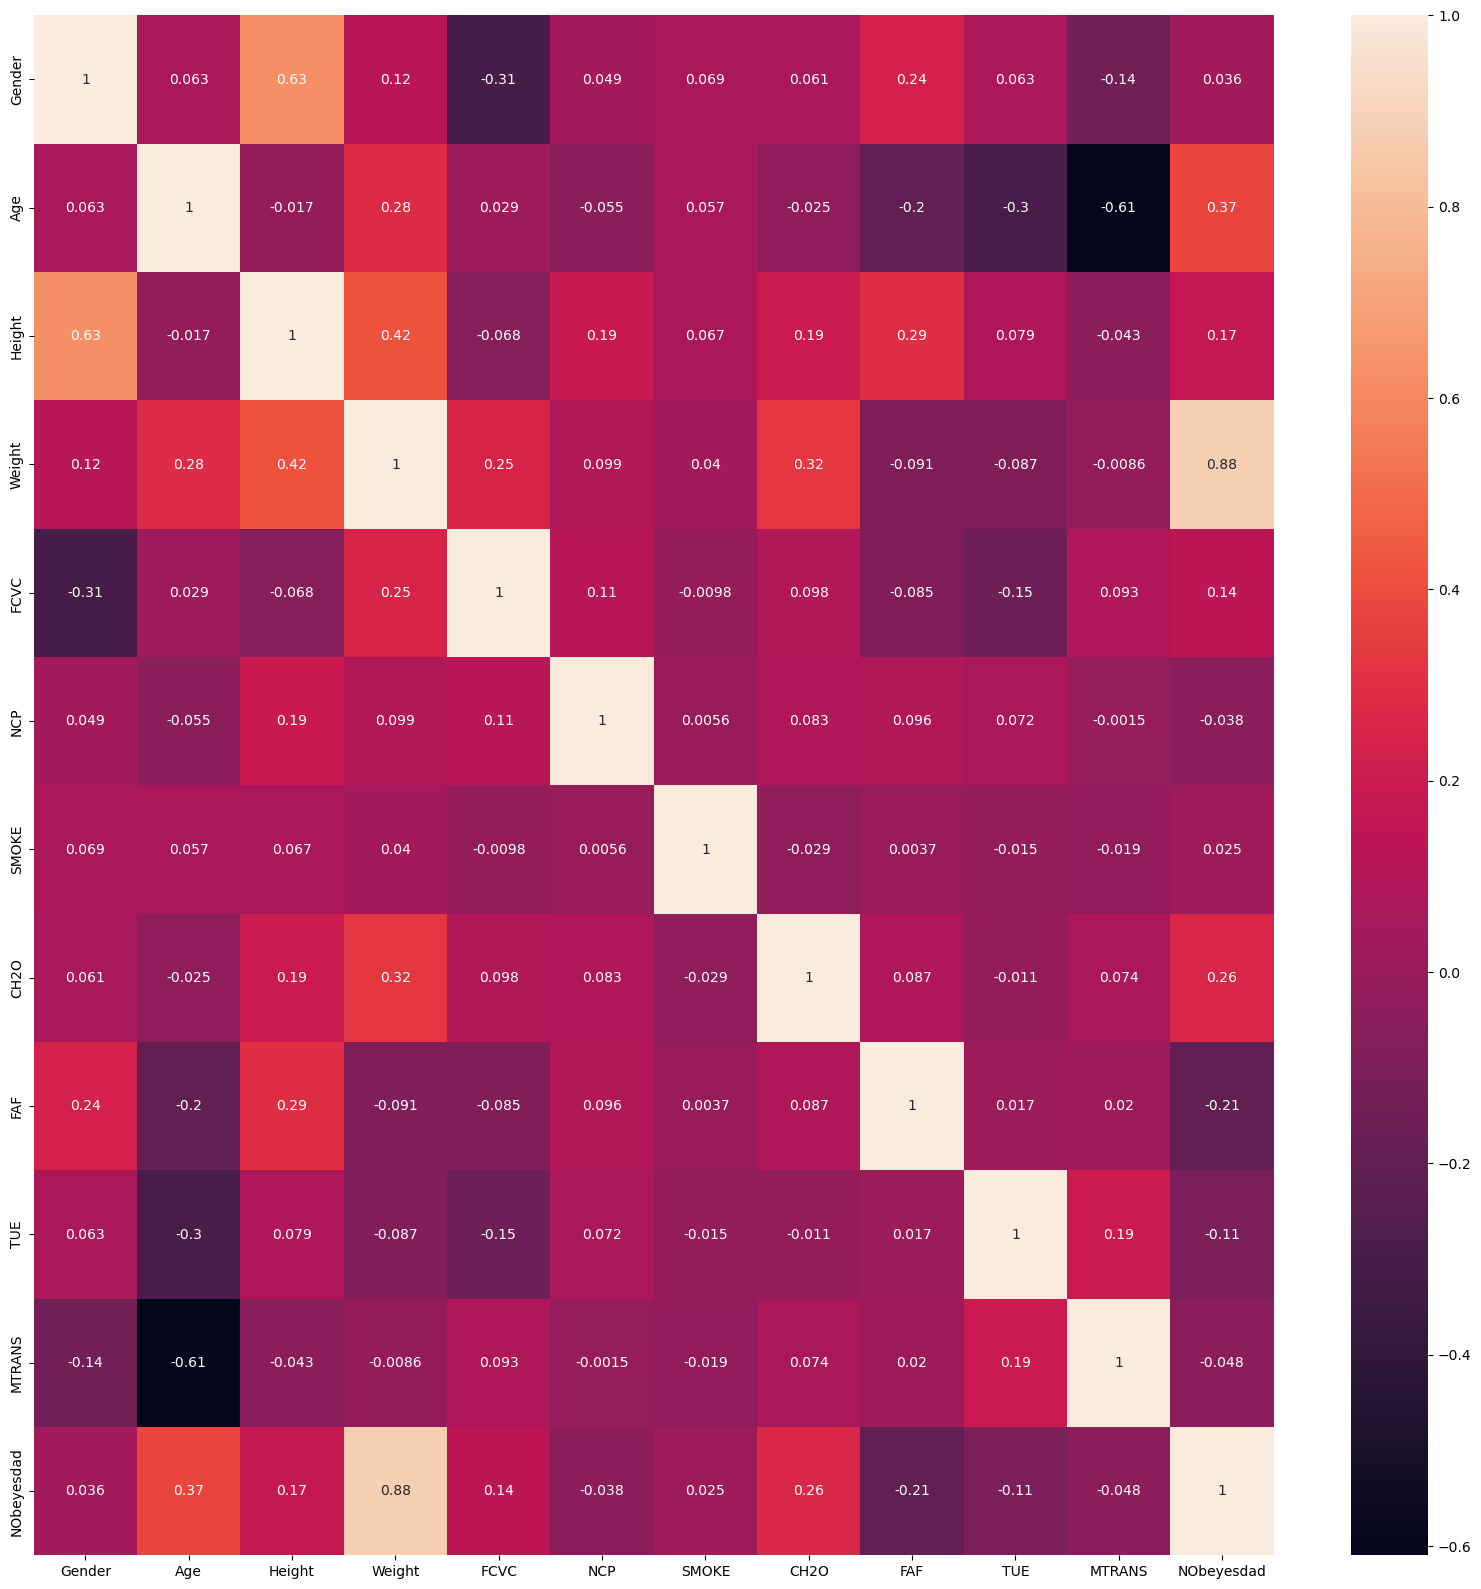

In [447]:
plt.figure(figsize=(20, 20))
sns.heatmap(data.corr(), annot=True)
plt.show()

## Handling the Missing Values
Handle the missing values using suitable method based on the insights obtained from the various visualizations.

In [449]:
data.isnull().mean() * 100

Gender        19.867039
Age           19.992292
Height        19.708064
Weight        20.623374
FCVC          19.833317
NCP           19.563542
SMOKE         19.799595
CH2O          20.045284
FAF           19.939301
TUE           19.977840
MTRANS        20.030831
NObeyesdad    19.910396
dtype: float64

## Feature Preprocessing


Preprocess the features to make them ready for using the model

In [452]:
data = data.dropna(subset=['FAF'])
data.isnull().sum()

Gender        3305
Age           3308
Height        3262
Weight        3397
FCVC          3315
NCP           3237
SMOKE         3293
CH2O          3338
FAF              0
TUE           3331
MTRANS        3381
NObeyesdad    3313
dtype: int64

In [453]:
#KNN na Weight - NObeyesdad
#KNN na Height - Gender
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Weight', 'NObeyesdad']])
knn_imputer = KNNImputer(n_neighbors=5)
imputed_data = knn_imputer.fit_transform(scaled_data)

In [454]:
data[['Weight', 'NObeyesdad']] = imputed_data

In [455]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Height', 'Gender']])
knn_imputer = KNNImputer(n_neighbors=5)
imputed_data = knn_imputer.fit_transform(scaled_data)
data[['Height', 'Gender']] = imputed_data
data['Gender'] = data['Gender'].round() #bidejki e kategoriska

In [456]:
data.isnull().sum()

Gender           0
Age           3308
Height           0
Weight           0
FCVC          3315
NCP           3237
SMOKE         3293
CH2O          3338
FAF              0
TUE           3331
MTRANS        3381
NObeyesdad       0
dtype: int64

In [457]:
#ostanatite so moda/medjana bidejki ne se vo nikakva zavisnost megju sebe
data.Age = data.Age.fillna(data.Age.median())

In [458]:
data.FCVC = data.FCVC.fillna(data.FCVC.median())
data.NCP = data.FCVC.fillna(data.NCP.median())
data.MTRANS = data.MTRANS.fillna(data.MTRANS.median())

In [459]:
data.isnull().sum()

Gender           0
Age              0
Height           0
Weight           0
FCVC             0
NCP              0
SMOKE         3293
CH2O          3338
FAF              0
TUE           3331
MTRANS           0
NObeyesdad       0
dtype: int64

In [460]:
data.TUE = data.TUE.fillna(data.TUE.median())
data.CH2O = data.CH2O.fillna(data.CH2O.median())

In [461]:
data['SMOKE'] = data['SMOKE'].fillna(0.0)
data.isnull().sum()

Gender        0
Age           0
Height        0
Weight        0
FCVC          0
NCP           0
SMOKE         0
CH2O          0
FAF           0
TUE           0
MTRANS        0
NObeyesdad    0
dtype: int64

In [462]:
from sklearn.model_selection import train_test_split

data_new = data.drop('FAF',axis=1)
X_train,X_test,Y_train,Y_test = train_test_split(data_new,data['FAF'],test_size=0.2)


## Hyper-parameter optimization

Train an XGBoost Model, optimize it's hyper-parameters with grid-search and 5-fold cross validation on the training set.

In [465]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

model = XGBRegressor()
param_grid={
    'max_depth':[2,6,8],
    'n_estimators':[20,40,60],
    'learning_rate':[0.1,0.01]
}
gs = GridSearchCV(param_grid=param_grid,estimator=model,verbose=1,n_jobs=-1,cv=5,scoring='r2')
gs.fit(X_train,Y_train)
print("Best params: ",gs.best_params_)
print("Best score: ",gs.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best params:  {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 60}
Best score:  0.31706934150349564


# Cross-validation evaluation

Perform leave-one out cross validation on the entire dataset, with an untrained model with the chosen hyper-parameters from the previous step.

In [507]:
best_model = gs.best_estimator_
best_model.fit(X_train,Y_train)
preds = best_model.predict(X_test)
from sklearn.metrics import r2_score
print("R2-score:",r2_score(Y_test,preds))

R2-score: 0.33049052989556915


Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [470]:
# Write your code here. Add as many boxes as you need.